#**Deep Learning Homework 2: *Optimize and Train Deep Models***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Deep Neural Network for a classification problem. We will learn how to use one of the most popular libraries for Deep Learning, namely [PyTorch 🔥](https://pytorch.org/). Then, we will see how to face a well known problem that is common during the training phase---overfitting on the training set. Finally, we will study how to perform a fair model selection.

<u>Disclaimer</u>: PyTorch is a complex framework actively used by researcher and developers all over the word. It is highly customizable and there are many other packages built along it. The purpose of this and the next homeworks is not to go into all the details of its functionalities, but rather to give you an overview of its applications and understand its rationale. There are many good tutorials online and we suggest you to look at the official [Learn the Basics Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html), in particular if you are not familiar with other Deep Learning Frameworks.

We hope that you will be able to use PyTorch by yourself for your future projects!

---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders.

## Requirements

In this first exercise we will develop a deep feed forward neural network to perform text classification.

Let's start by importing the libraries we will need (this may take some minutes) and setting a couple of environmental variables.

In [1]:
!python --version

Python 3.10.12


In [2]:
!pip3 install skorch torchtext torchview hiddenlayer portalocker

##Imports

In [3]:
import torch
import torch.nn.functional as F
from torchtext.datasets import CoLA
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from skorch.helper import SliceDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import os
import multiprocessing
from timeit import default_timer as timer
from torchview import draw_graph
import matplotlib.pyplot as plt
import hiddenlayer as hl

In [4]:
logging.disable(logging.WARNING)

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

torch.__version__='2.2.1+cu121'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 535.104.05, 15360 MiB, 3 MiB, 15099 MiB


#Data Loading and Preprocessing

### Load Dataset: CoLA

In this HW, we use the Corpus of Linguistic Acceptability (CoLA) dataset that is available in Torchtext. The CoLA dataset in its full form consists of $10657$ sentences from $23$ linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. The public version provided contains $9594$ sentences belonging to training and development (a.k.a. validation) sets, and excludes $1063$ sentences belonging to a test set. We are thus dealing with text binary classification, wheter a sentence is acceptable or not (0=unacceptable, 1=acceptable).

In [5]:
# Get data splits
train, val, test = CoLA(root="dataset", split=('train', 'dev', 'test'))

# Preprocess
preprocess = lambda x: (x[1], x[2]) # the first item of each sample (x[0]) is not useful for our case and hence discarded
train_data = list(map(preprocess, train))
val_data = list(map(preprocess, val))
test_data = list(map(preprocess, test))

rng.shuffle(train_data)
rng.shuffle(val_data)
rng.shuffle(test_data)

In [6]:
# Check sizes
len(train_data), len(val_data), len(test_data)

(8550, 526, 515)

In [7]:
# This dataset is not balanced, making it harder to predict the least frequent class
balance_check = lambda x: sum([x[k][0] for k in range(len(x))]) / len(x)
print(f"{100*balance_check(train_data):.2f}% of training data are labeled 1")
print(f"{100*balance_check(val_data):.2f}% of validation data are labeled 1")
print(f"{100*balance_check(test_data):.2f}% of test data are labeled 1")

70.43% of training data are labeled 1
69.20% of validation data are labeled 1
68.54% of test data are labeled 1


In [8]:
# We will try to reduce this imbalance by oversampling 0-labeled data points. There are other possible approaches to deal with imbalanced datasets, e.g. tweaking the loss function.
neg_train_data = [train_data[k] for k in range(len(train_data)) if train_data[k][0] == 0]
train_data += neg_train_data
neg_val_data = [val_data[k] for k in range(len(val_data)) if val_data[k][0] == 0]
val_data += neg_val_data

In [9]:
len(train_data), len(val_data), len(test_data)

(11078, 688, 515)

In [10]:
print(f"{100*balance_check(train_data):.2f}% of training data are labeled 1")
print(f"{100*balance_check(val_data):.2f}% of validation data are labeled 1")
print(f"{100*balance_check(test_data):.2f}% of test data are labeled 1")

54.36% of training data are labeled 1
52.91% of validation data are labeled 1
68.54% of test data are labeled 1


And have a look at one sample:

In [11]:
idx = 10
sample_label, sample_text = train_data[idx]
print(f"Text: {sample_text}")
print(f"Label: {sample_label}") # 0=gramatically correct; 1=gramatically wrong

Text: John is the kind of a fool that I told you about.
Label: 1


### Data Preprocessing
We will go though the basic data processing building blocks for raw text string.
Given a string, the first step is to tokenize the data to prepare it as input for the model. For this purpouse, we will use the basic Tokenizer of PyTorch. As you can see, it just normalizes the text, removes whitespaces and unsupported characters, and outputs a list:

In [12]:
tokenizer = get_tokenizer('basic_english')
print("Example: ", tokenizer("I'm so HAPPY to study Deep Learning! #UNIPD #UniLIFE"))

Example:  ['i', "'", 'm', 'so', 'happy', 'to', 'study', 'deep', 'learning', '!', '#unipd', '#unilife']


The CoLA dataset consists of simple sequences of words. Since we have to encode each sample in a single tensor with a fixed number of elements, we will build a vocabulary of the sentences available in our training set. In other words, we tokenize all the training set, and map each unique word into a number (a.k.a. index). This is necesseray as Neural Networks process numbers, so such vocabulary simply translates between readable words and numbers.

In [13]:
def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

# We limit our model to learn from the first 100 most frequent tokens
vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<unk>"], max_tokens=100) # <unk> is the index we use for specials characters ...
vocab.set_default_index(vocab["<unk>"]) # ... and 0 as the default values for tokens out of the vocabulary (OOV)
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 100 tokens-index pairs.


This vocabulary was build from the training set. Let us see what it does on our example:

In [14]:
# Let us define some useful functions to handle tokens and labels
text_pipeline = lambda x: vocab(tokenizer(x)) # useful function to go from string -> tokens

In [15]:
sample_tokenization = text_pipeline(sample_text)
print(f"Samlpe text:\n {sample_text}")
print(f"Sample text to tokens:\n {sample_tokenization}")
print(f"Label:\n {sample_label}")

Samlpe text:
 John is the kind of a fool that I told you about.
Sample text to tokens:
 [8, 7, 2, 0, 11, 4, 0, 6, 5, 0, 17, 75, 1]
Label:
 1


So each word is correctly mapped into a number, where most frequent words come first (see how the article "the", which is very frequent, gets translated to the number $2$). Notice also how "fool" takes the default index value of $0$, meaning that is not frequent in the training set.

Neural Netowrks (usually) take input of fixed size, but these sentences have different lenghts! To tackle this issue, one way is to resort to _multi-hot-encoding_ our dataset, means turning it into a tensor of $0$ and $1$. Concretely, this would mean for instance turning the sequence `[3, 5]` into a $100$-dimensional vector (our vocabulary) that would be all zeros except for indices 3 and 5, which would be ones. The obtained input representation indicates which words are present (at least one time) in the sentence.

In [16]:
def multi_freq_hot(token_list, n_cat=len(vocab)):
  encoded = [token_list.count(i) if i in token_list else 0 for i in range(n_cat)]
  return encoded

The next step is building a PyTorch  `Dataset` and `DataLoader`. Without going too much into the details, a `DataLoader` is the object one uses in the `for` loops when iterating over the data for training or inference. It has some additional benefits and pourpouses over iterating usual lists, such as multiprocessing, data transformation, sampling or shuffling. Don't worry too much for now, as we do this part for you.

In [17]:
class MyDataset(Dataset):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    # This makes sure we preprocess the data as above ready for PyTorch format
    label, text = self.dataset[idx]
    txt = multi_freq_hot(text_pipeline(text))
    lb, txt = torch.tensor(label, dtype=torch.float32, device=device), torch.tensor(txt, dtype=torch.float32, device=device)
    return lb.view(1), txt

In [18]:
train_dataset = MyDataset(train_data)
val_dataset = MyDataset(val_data)
test_dataset = MyDataset(test_data)

In [19]:
batch_size = 32
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Let's see what we get at every iteration of training DataLoaders: a batch of 32 labels (size = 1) and texts (size = 100)
next(iter(dataloader_training))[0].shape, next(iter(dataloader_training))[1].shape

(torch.Size([32, 1]), torch.Size([32, 100]))

# Exercise 2.1: Model Definition and Training
We can now define the 3-layers feed forward linear model!
In PyTorch we do that by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In detail, we created a `FeedforwardNetwork` class. The constructor takes three arguments: `input_dim` (an integer), which is the dimension of the input layer; `num_classes` (an integer), which is the number of output classes; and `hidden_layers_dim` (a list of integers), which is the dimension of the hidden layers in the network.

In the constructor, the `nn.ModuleList() ` object is initialized to hold the layers of the network. If `hidden_layers_dim` is an empty list, then the network only consists of a single linear layer (from input to output). Otherwise, the network consists of multiple linear layers. The first layer goes from the input layer to the first hidden layer, and the subsequent hidden layers go from the previous hidden layer to the next hidden layer. The final output layer goes from the last hidden layer to the output layer.

The `_init_weights` function is a helper function that initializes the weights of the linear layers in the network (you can try it out yourself).

The `forward` function defines the forward pass of the network. It first checks whether the network has only one layer (in which case it simply returns the output of that layer). Otherwise, it applies the `relu` activation function to the output of each hidden layer and passes the result to the next layer. Finally, it returns the output of the final layer.

In [21]:
class FeedForwardNetwork(nn.Module):

  def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
    super().__init__()
    if num_classes == 2: num_classes = num_classes -1
    self.layers = nn.ModuleList()
    if len(hidden_layers_dim) == 0:
      self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
    else:
      for layer_idx in range(len(hidden_layers_dim)):
        if layer_idx == 0:  # first layer, from input to hidden
          self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
        else:  # hidden layers, depending on the input
          self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
      self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
    # self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        # module.weight.data.normal_(mean=0.0, std=.1)
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(self, x):
    if len(self.layers) == 1:
      return torch.sigmoid(self.layers[0](x))
    else:
      for layer in self.layers[:-1]:
        x = F.relu(layer(x))
    return torch.sigmoid(self.layers[-1](x))

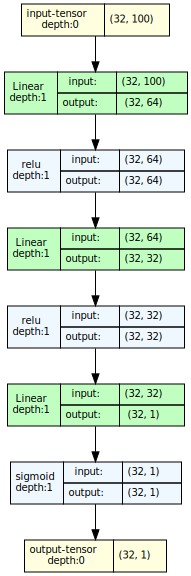

In [22]:
# Now we prepare our model for this specific dataset and exercise
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
EPOCHS = 40
lr = 1e-5
model = FeedForwardNetwork(vocab_size, num_class, hidden_layers_dim=[64, 32]).to(device)
# Let us see a nice drawing of our Netwokrk :-)
model_graph = draw_graph(model, input_size=(batch_size, vocab_size), device=device)
model_graph.visual_graph

In [23]:
# We need to defin our loss function (Binary Cross Entropy for binary classification) and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Finally, we can define the training procedure. In PyTorch there are few rules to follow to train a model, and they became pretty standard and widespreaded. This time try on your own to understand what each line of code is doing and refer to the official documentation, it will be required for the following HWs and exercises!

In [24]:
def train(model, optimizer, dataloader_train, dataloader_val, EPOCHS=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  history1 = hl.History() # This is a simple tool for logging
  canvas1 = hl.Canvas() # This is a simple tool for plotting
  for epoch in range(EPOCHS):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      pred_label = torch.where(logits > 0.5, 1.0, 0.0)
      accuracy = (pred_label == label).sum().item()

      total_acc_train += accuracy
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            pred_label = torch.where(logits > 0.5, 1.0, 0.0)
            total_acc_val += (pred_label == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      history1.log(epoch, train_loss=avg_loss_train, train_accuracy=accuracy_train,
                   val_loss=avg_loss_val, val_accuracy=accuracy_val)#,

      with canvas1:
        canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])
        canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]])

  return loss_train, acc_train, loss_val, acc_val

Let's train it! 🏋

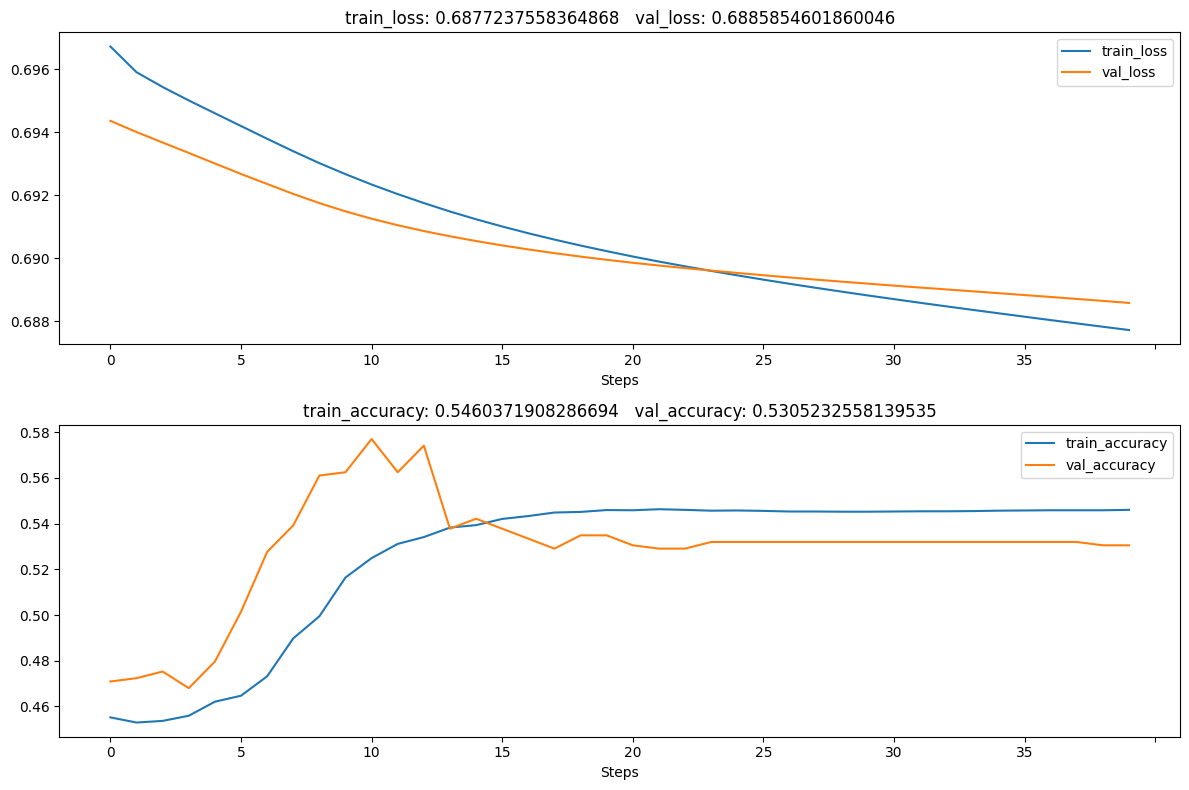

Training time in second: 115.85846289000006


In [25]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

## Q1: Custom Activation Function [TO COMPLETE]
So far we have provided you a basic working model. As first exercise, we ask you to extend it by implementing a custom activation function. This means that you have to:
1. Define a class `CustomFeedForwardNetwork` similar to the previous example, but which additionaly takes an `activation_function` at initialization.
2. Implement the `activation_function` correctly in the class and forward pass.
3. Implement from scratch any activation function. Do not use directly the ones available in `torch.nn.functional`, but you can get some inspiration there.
4. Train a model with your custom activation function.

`%STARTCODE`

In [26]:
class CustomFeedForwardNetwork(nn.Module):

  def __init__(self, input_dim, num_classes, hidden_layers_dim=[], function = F.relu):
    super().__init__()
    self.function = function
    if num_classes == 2: num_classes = num_classes -1
    self.layers = nn.ModuleList()
    if len(hidden_layers_dim) == 0:
      self.layers.append(nn.Linear(input_dim, num_classes))
    else:
      for layer_idx in range(len(hidden_layers_dim)):
        if layer_idx == 0:  # first layer, from input to hidden
          self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
        else:  # hidden layers, depending on the input
          self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
      self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
    # self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        # module.weight.data.normal_(mean=0.0, std=.1)
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            module.bias.data.zero_()

  def forward(self, x):
    if len(self.layers) == 1:
      return torch.sigmoid(self.layers[0](x))
    else:
      for layer in self.layers[:-1]:
        x = self.function(layer(x))
    return torch.sigmoid(self.layers[-1](x))

In [27]:
def activation_function(x):
  return 1 / (1 + torch.exp(-x))

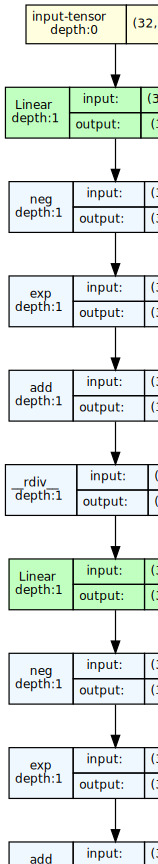

In [28]:
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
EPOCHS = 40
lr = 1e-5
custom_model = CustomFeedForwardNetwork(vocab_size, num_class, hidden_layers_dim=[64, 32], function=activation_function).to(device)
model_graph = draw_graph(custom_model, input_size=(batch_size, vocab_size), device=device)
model_graph.visual_graph

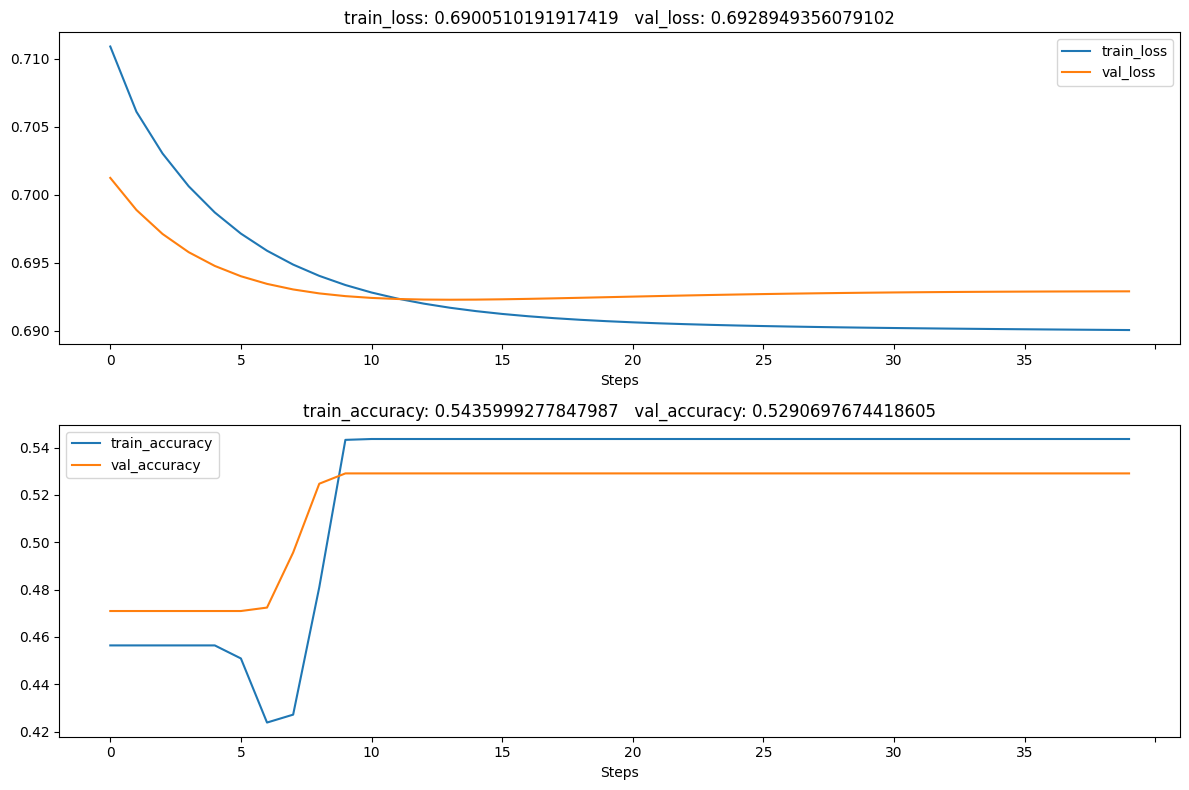

Training time in second: 109.14815115700003


In [29]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=lr)
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(custom_model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

`%ENDCODE`

## Q2: Evaluate the Model [TO COMPLETE]

Now, let's go back on our first model. It has been optimized on the training set, and as you can see the performance on the validation set in quite similar (so it does not overfit the training data). Let's now evaluate the performance of our model using the test set. By having a look at the previous code, compute the performances on the test set.

`%STARTCODE`

In [31]:
model.eval() # This is important!
total_acc_test, total_count_test, n_batches_test, total_loss_test = 0, 0, 0, 0
for idx, (label, text) in enumerate(dataloader_test):
    logits = model(text)
    loss = criterion(logits, label)
    total_loss_test += loss.item()

    pred_label = torch.where(logits > 0.5, 1.0, 0.0)
    total_acc_test += (pred_label == label).sum().item()
    total_count_test += label.size(0)
    n_batches_test += 1

accuracy_test = total_acc_test/total_count_test
loss_test = total_loss_test/n_batches_test
print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
print(f"Test Accuracy: {100*accuracy_test:.4f}%")


Test Loss: 0.67188635 ---------- Test Accuracy: 68.3495%


`%ENDCODE`

# Exercise 2.2: Overfitting

A common problem that occurs when you train a deep neural network is overfittig. Overfitting occurs when you achieve a good fit of your model on the training data, while it does not generalize well on new, unseen data. In other words, the model learned patterns specific to the training data, which are irrelevant in other cases.
As we have seen in the previous exercise, our model does not much overfit the training data. In this exercise, we try to modify the training parameters in order to have a model that overfits.
Overfitting can have many causes and usually is a combination of some of them, for instance: too many parameters/layers, too few training samples, wrong learning rate (usualy too high), ...


## Q3: Overfitting Model [TO COMPLETE]
In the next cell define a new model (from the class `FeedForwardNetwork`) that overfits the training data; then plot the trend of the accuracy and loss in training and validation set.

As a reference, you should get that at the end the training accuracy is even $>30\%$ than the validation accuracy, that on the contrary sould stay quite constant thourghout the epochs. The more your model overfits, the easier it will be to carry out the following exercises.


`%STARTCODE`

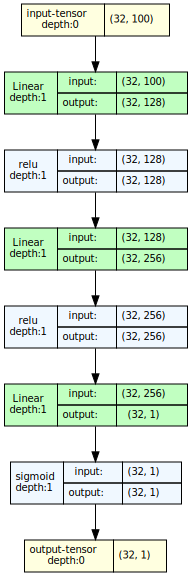

In [32]:
EPOCHS = 40
lr = 1e-4
overfit_model = FeedForwardNetwork(vocab_size, num_class, hidden_layers_dim=[128, 256]).to(device) #[TO COMPLETE]
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
model_graph = draw_graph(overfit_model, input_size=(batch_size, vocab_size), device=device)
model_graph.visual_graph

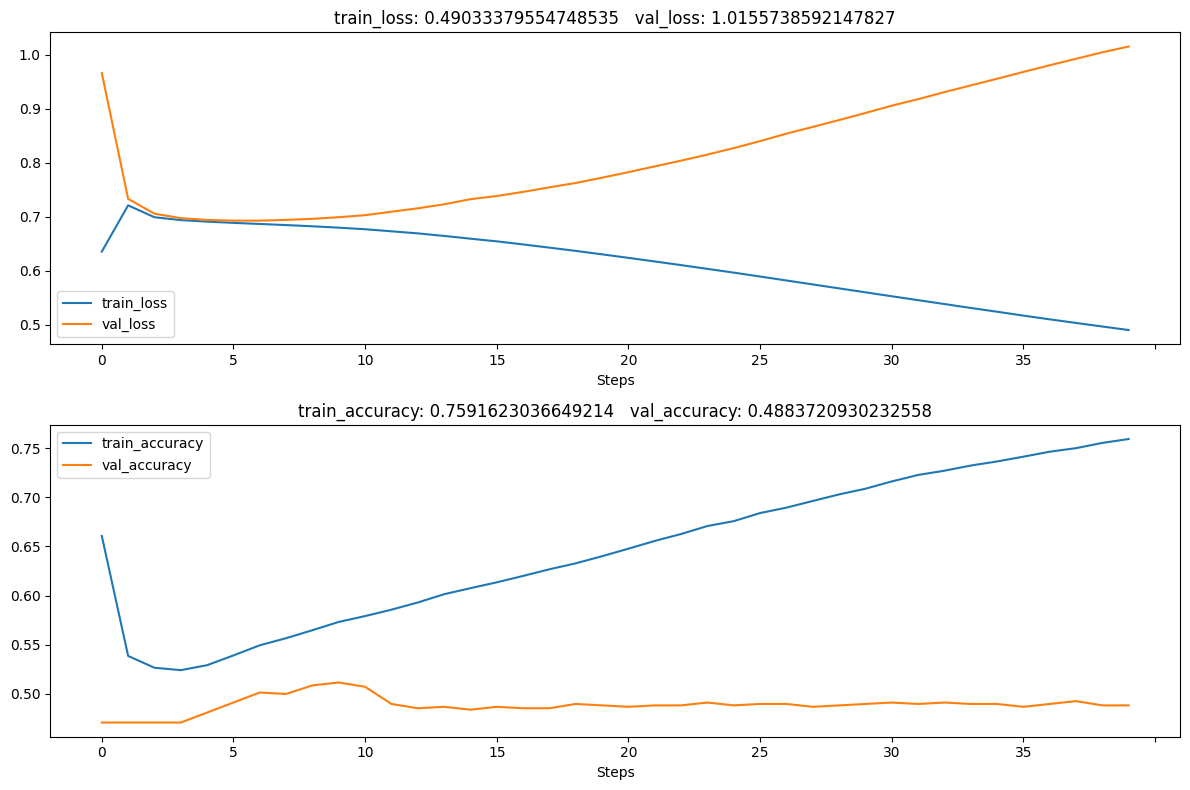

Training time in second: 106.15756179899995


In [33]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(overfit_model, optimizer, dataloader_training, dataloader_validation)
end = timer()
print(f"Training time in second: {(end - start)}")

`%ENDCODE`

# Exercise 2.3: $L^p$-regularization
One possible way to solve the overitting issue is by using regularization methods. The two most common regularization methods in Deep Learning are the L1-norm regularization and the L2-norm regularization. Both These techniques are based on limiting the capacity of models, by adding a parameter norm penalty to the loss function $\mathcal{L}$:
$$
\hat{\mathcal{L}}(\theta,\mathbf{X},\mathbf{y}) = \mathcal{L}(\theta,\mathbf{X},\mathbf{y}) + \lambda L^p(\theta)
$$
where $\lambda$ is a hyperparameter that weighs the relative contribution of the norm penalty $L^p$ on a lernable parameter vector $\theta$:
$$
 L^p(\theta)=||\theta||_p=\left(\sum_i |\theta_i|^p\right)^{1/p}
$$

**[TO COMLPETE]**: Implement the $L^2$ regularization for the overfitting model. Such regularization can either be implemented from scratch or using `torch.linalg` methods, but not using the implementations embedded in Torch optimizers!


### Q4: $L^2$ Regularization [TO COMPLETE]

`%STARTCODE`

In [34]:
def train_L2(model, optimizer, dataloader_train, dataloader_val, l2_lambda, EPOCHS=EPOCHS): # <--- We pass the lambda hyperparameter
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  history1 = hl.History()
  canvas1 = hl.Canvas()
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      ##########################################################
      l2_norm = 0
      for param in model.parameters():
        l2_norm += torch.sum(param ** 2) # TO COMPLETE
      loss_w_l2 = loss + l2_lambda * l2_norm# TO COMPLETE
      ##########################################################
      total_loss_train += loss
      loss_w_l2.backward()
      optimizer.step()

      pred_label = torch.where(logits > 0.5, 1.0, 0.0)
      accuracy = (pred_label == label).sum().item()

      total_acc_train += accuracy
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            pred_label = torch.where(logits > 0.5, 1.0, 0.0)
            total_acc_val += (pred_label == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      history1.log(epoch, train_loss=avg_loss_train, train_accuracy=accuracy_train,
                   val_loss=avg_loss_val, val_accuracy=accuracy_val)
      with canvas1:
        canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])
        canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]])

  return loss_train, acc_train, loss_val, acc_val

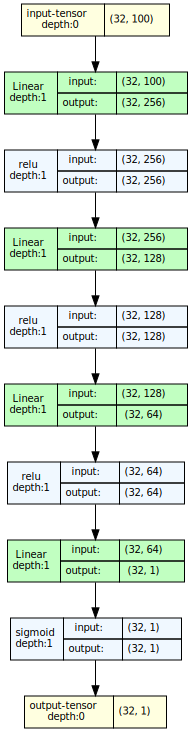

In [35]:
EPOCHS = 40
lr = 1e-4
# Load the previous (untrained) overfit_model with the same parameters
overfit_model = FeedForwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
model_graph = draw_graph(overfit_model, input_size=(batch_size, vocab_size), device=device)
model_graph.visual_graph

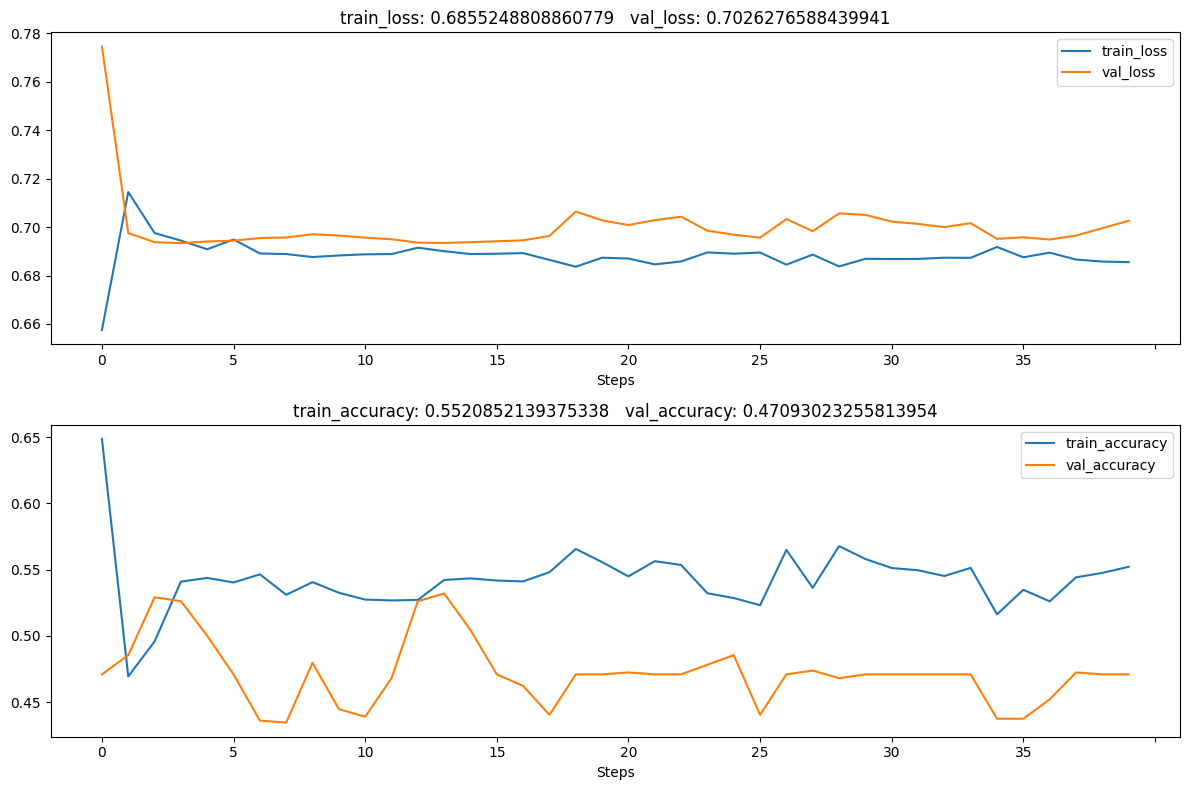

Training time in second: 123.12266183399993


In [36]:
start = timer()
l2_lambda = 0.01# TO COMPLETE
loss_train, accuracy_train, loss_val, accuracy_val = train_L2(overfit_model, optimizer, dataloader_training, dataloader_validation, l2_lambda=l2_lambda)
end = timer()
print(f"Training time in second: {(end - start)}")

`%ENDCODE`

# Exercise 2.4: Early Stopping
Early Stopping is a form of regularization used to avoid overfitting. It is designed to monitor the generalization error of one model and stop training when generalization error begins to degrade. In order to evaluate the generalization error, early stopping requires that a validation dataset is evaluated during training. Then, when the validation error does not improve for a specific number of epochs (a.k.a. the "patience" or "tolerance" hyperparameter), it stops the training phase.

To implement it in PyTorch, we define a simple classes that does this job.

In [37]:
class EarlyStopping:
    def __init__(self, tolerance, min_delta):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

### Q5: Early Stopping [TO COMPLETE]

Define a training procedure with Early Stopping class and check its performances.

`%STARTCODE`

In [38]:
def train_early_stop(model, optimizer, dataloader_train, dataloader_val, tolerance, min_delta, EPOCHS=EPOCHS): # <--- We pass the hyperparameters
  ###########################################################
  early_stopping = EarlyStopping(tolerance, min_delta)# TO COMPLETE
  ###########################################################
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  history1 = hl.History()
  canvas1 = hl.Canvas()
  for epoch in range(EPOCHS):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      pred_label = torch.where(logits > 0.5, 1.0, 0.0)
      accuracy = (pred_label == label).sum().item()

      total_acc_train += accuracy
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            pred_label = torch.where(logits > 0.5, 1.0, 0.0)
            total_acc_val += (pred_label == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:

      history1.log(epoch, train_loss=avg_loss_train, train_accuracy=accuracy_train,
                   val_loss=avg_loss_val, val_accuracy=accuracy_val)

      with canvas1:
        canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])
        canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]])

    ############################################################
    # TO COMPLETE - Implement Early Stopping
    early_stopping(avg_loss_train.item(), avg_loss_val.item())
    if early_stopping.early_stop:
      print("Early stopping")
      break
    ############################################################
  return loss_train, acc_train, loss_val, acc_val

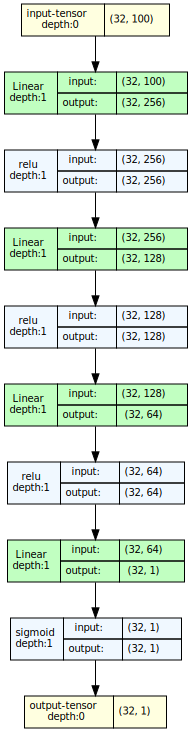

In [39]:
EPOCHS = 40
lr = 1e-4
# Load the previous (untrained) overfit_model with the same parameters
overfit_model = FeedForwardNetwork(vocab_size, num_class, hidden_layers_dim=[256, 128, 64]).to(device)
optimizer = torch.optim.Adam(overfit_model.parameters(), lr=lr)
model_graph = draw_graph(overfit_model, input_size=(batch_size, vocab_size), device=device)
model_graph.visual_graph

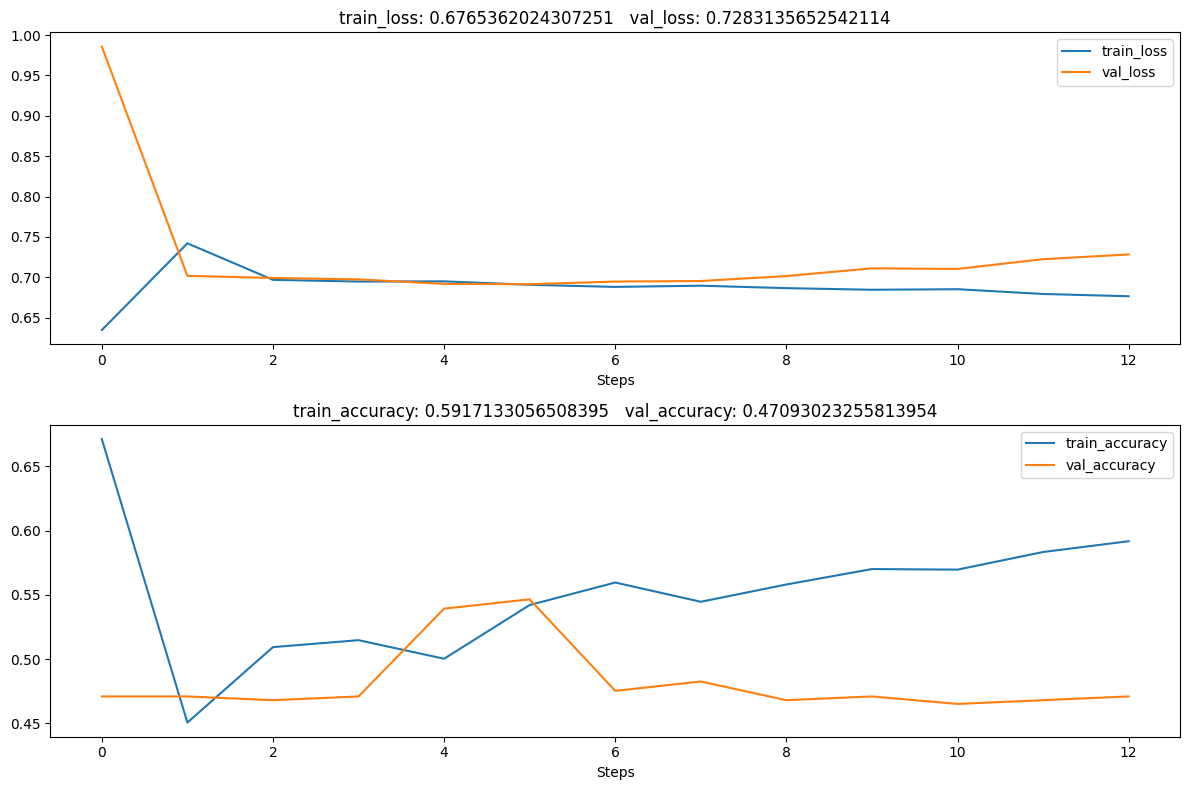

Early stopping
Training time in second: 35.00107432599998


In [40]:
# Define Early Stopping parameters
tolerance = 5# TO COMPLETE
min_delta = 0.02# TO COMPLETE

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_early_stop(overfit_model, optimizer, dataloader_training, dataloader_validation, tolerance, min_delta)
end = timer()
print(f"Training time in second: {(end - start)}")

`%ENDCODE`

# Exercise 2.5: Model Selection
Hyperparameters are the parameters of the learning method itself which we have to specify a priori, i.e., before model fitting. In contrast, model parameters are parameters which arise as a result of the fit (the network weights). The aim of model selection is selecting the best hyperparameters for our deep network. Finding the right hyperparameters for a model can be crucial for the model performance on given data.

### Q6: Grid Search [TO COMPLETE]

Since a deep net has many hyperparameters, to find the best ones we have to consider different possible combinations of values for each hyperparameter. One common method to perform this complex task is Grid-Search.
Given a set of values for each hyperparameter, the Grid-Search algorithm will build a model on all possible parameter combinations. It iterates through every parameter combination and stores a model for each combination. Finally, the model that obtained the best result on the validation set will be selected and tested.

In order to perfrom Grid-Search we will use the `GridSearchCV` class from `scikit-learn`, together with some classes from the `skorch` package which allows to use PyTorch models with `scikit-learn`.

In [41]:
model = NeuralNetClassifier(
    module=FeedForwardNetwork,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=20)

# we need to adapt PyTorch Dataset to work with Scikit-Learn GridSearchCV
# we use the SliceDataset class from skorch package for this purpose
X_slice = SliceDataset(train_dataset, idx=1)
y_slice = SliceDataset(train_dataset, idx=0)

Let's define the lists of hyper-parameters' values. Also in this case, we use dictionaries of very limited size and hyperparameters, but in a real-world scenario a reasonable amount of possible values should be considered (and there are better search algorthims besisdes Grid-Search).

**[TO COMPLETE]**: Define a Grid Search of plausible hyperparameters:


`%STARTCODE`

In [42]:
params = {
    'lr': [0.01], # TO COMPLETE -> I made various but for the sake of testing, this was the best one
    'module__input_dim': [100], # TO COMPLETE
    'module__num_classes': [2], # TO COMPLETE it is a binary classification
    'module__hidden_layers_dim': [[100, 128],[100, 64]], # TO COMPLETE
    }

`%ENDCODE`

Now you can use `sklearn`'s `GridSearchCV` to search the hyperparameter space of the `NeuralNetClassifier`:

In [43]:
n_jobs = multiprocessing.cpu_count()-1
print(f"Parallel jobs: {n_jobs}")
gs = GridSearchCV(model, params, n_jobs=n_jobs, verbose=2)

Parallel jobs: 1


In [44]:
outputs = gs.fit(X_slice, y_slice)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.0000       0.4563        0.0000  1.9299
      2        0.0000       0.4563        0.0000  2.4468
      3        0.0000       0.4563        0.0000  2.2498
      4        0.0000       0.4563        0.0000  1.9297
      5        0.0000       0.4563        0.0000  1.9529
      6        0.0000       0.4563        0.0000  1.9694
      7        0.0000       0.4563        0.0000  1.9753
      8        0.0000       0.4563        0.0000  2.7327
      9        0.0000       0.4563        0.0000  1.9437
     10        0.0000       0.4563        0.0000  1.9300
     11        0.0000       0.4563        0.0000  1.9358
     12        0.0000       0.4563        0.0000  1.9526
     13        0.0000       0.4563        0.0000  1.8985
     14        0.0000       0.4563        0.0000  2.7570
     15        0.0000       

Print the best hyper-parameters and the performances on the best model on the test set:

`%STARTCODE`

In [45]:
print("Best score: {:.3f}, Best Params: {}".format(gs.best_score_, gs.best_params_))

Best score: 0.456, Best Params: {'lr': 0.01, 'module__hidden_layers_dim': [100, 128], 'module__input_dim': 100, 'module__num_classes': 2}


`%STARTCODE`